# ECBM E6040 Homework 2 - Programming Problem

In [1]:
"""
Code for Homework 2 of ECBM E6040, Spring 2016, Columbia University

Instructor: Prof. Aurel A. Lazar

This code is based on
[1] http://deeplearning.net/tutorial/logreg.html
[2] http://deeplearning.net/tutorial/mlp.html
"""

from __future__ import print_function

__docformat__ = 'restructedtext en'


import os
import sys
import timeit

import numpy
import scipy.io

import theano
import theano.tensor as T
from hw2b import load_data, LogisticRegression, HiddenLayer

# TODO: problem b, bullet 1
class myMLP(object):
    def __init__(self, rng, input, n_in, n_out, n_layer, activation):
        self.hiddenLayer = []
        self.hiddenLayer.append(HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_layer[0],
            activation=activation
        ))

        for i in range(1, len(n_layer)):
            self.hiddenLayer.append(HiddenLayer(
                rng=rng,
                input=self.hiddenLayer[-1].output,
                n_in=n_layer[i-1],
                n_out=n_layer[i],
                activation=activation
            ))

        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer[-1].output,
            n_in=n_layer[-1],
            n_out=n_out
        )
        self.L1 = (
            reduce(lambda y, x: y+abs(x.W).sum(), self.hiddenLayer, 0.0)
            + abs(self.logRegressionLayer.W).sum()
        )
        self.L2_sqr = (
            reduce(lambda y, x: y+(abs(x.W)**2).sum(), self.hiddenLayer, 0.0)
            + (self.logRegressionLayer.W ** 2).sum()
        )

        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        self.errors = self.logRegressionLayer.errors

        self.params = reduce(lambda x, y: x+y.params, self.hiddenLayer, []) + self.logRegressionLayer.params

        self.input = input

# TODO: you might need to modify the interface
def test_mlp(datasets, learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000,
             batch_size=20, verbose=True, n_layer=[500, 500], activation=T.tanh):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization)

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type verbose: boolean
    :param verbose: to print out epoch summary or not to

    """

    # load the dataset; download the dataset if it is not present
    #datasets = load_data()

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(1234)

    # construct the MLP class
    '''
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=32*32*3,
        n_hidden=n_hidden,
        n_out=10,
    )
    '''

    # TODO: use your MLP
    classifier = myMLP(
        rng=rng,
        input=x,
        n_in=32*32*3,
        n_layer=n_layer,
        activation=activation,
        n_out=10,
    )

    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.99  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)

                if verbose:
                    print(
                        'epoch %i, minibatch %i/%i, validation error %f %%' %
                        (
                            epoch,
                            minibatch_index + 1,
                            n_train_batches,
                            this_validation_loss * 100.
                        )
                    )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (
                        this_validation_loss < best_validation_loss *
                        improvement_threshold
                    ):
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [test_model(i) for i
                                   in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)

                    if verbose:
                        print(('     epoch %i, minibatch %i/%i, test error of '
                               'best model %f %%') %
                              (epoch, minibatch_index + 1, n_train_batches,
                               test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f %% '
           'obtained at iteration %i, with test performance %f %%') %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print(('The code for file ' +
           os.path.split('__file__')[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)
    return 1.0-test_score

Using gpu device 0: GRID K520


### Bullet 2: Comparison between _tanh_ and _softmax_

#### Using softmax
Parameters:
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 1000
* batch_size = 20
* n_layers = [250, 250]
* activation = T.nnet.softmax

In [2]:
datasets = load_data()
acc_softmax = test_mlp(datasets=datasets, activation=T.nnet.softmax, n_epochs=250, n_layer=[250, 250])
print('Best test accuracy with softmax activation is {}.'.format(acc_softmax))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 81.161202 %
     epoch 1, minibatch 3296/3296, test error of best model 80.415065 %
epoch 2, minibatch 3296/3296, validation error 81.161202 %
epoch 3, minibatch 3296/3296, validation error 81.161202 %
Optimization complete. Best validation score of 81.161202 % obtained at iteration 3296, with test performance 80.415065 %
Best test accuracy with softmax activation is 0.195849346656.


The code for file __file__ ran for 0.70m


#### Using tanh
Parameters:
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 250
* batch_size = 20
* n_layer = [250, 250]
* activation = T.tanh

In [9]:
datasets = load_data()
acc_softmax = test_mlp(datasets=datasets, activation=T.tanh, n_epochs=200, n_layer=[250, 250])
print('Best test accuracy with tanh activation is {}.'.format(acc_softmax))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 81.038251 %
     epoch 1, minibatch 3296/3296, test error of best model 80.330515 %
epoch 2, minibatch 3296/3296, validation error 63.620219 %
     epoch 2, minibatch 3296/3296, test error of best model 64.177556 %
epoch 3, minibatch 3296/3296, validation error 49.549180 %
     epoch 3, minibatch 3296/3296, test error of best model 52.659493 %
epoch 4, minibatch 3296/3296, validation error 42.185792 %
     epoch 4, minibatch 3296/3296, test error of best model 45.134512 %
epoch 5, minibatch 3296/3296, validation error 38.169399 %
     epoch 5, minibatch 3296/3296, test error of best model 41.010761 %
epoch 6, minibatch 3296/3296, validation error 35.969945 %
     epoch 6, minibatch 3296/3296, test error of best model 38.312836 %
epoch 7, minibatch 3296/3296, validation error 34.057377 %
     epoch 7, minibatch 3296/3296, test error of best model 36.337433 %
epoch 8, minibatch 3296/3296, 

The code for file __file__ ran for 16.00m


**Observation**

The situation with softmax activation function get much worse result than that with tanh activation function, meaning the accuracy depends largely on the choice of activation function category.

### Bullet 3: Experiment with the number of hidden layers

In [10]:
datasets = load_data()
acc_3 = []
for i in range(1, 9):
    n_layer = [250 for j in range(i)]
    acc_3.append(test_mlp(datasets=datasets, activation=T.tanh, n_layer=n_layer, n_epochs=250))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 80.778689 %
     epoch 1, minibatch 3296/3296, test error of best model 80.153728 %
epoch 2, minibatch 3296/3296, validation error 71.816940 %
     epoch 2, minibatch 3296/3296, test error of best model 71.906226 %
epoch 3, minibatch 3296/3296, validation error 59.207650 %
     epoch 3, minibatch 3296/3296, test error of best model 60.395849 %
epoch 4, minibatch 3296/3296, validation error 49.918033 %
     epoch 4, minibatch 3296/3296, test error of best model 51.936972 %
epoch 5, minibatch 3296/3296, validation error 42.950820 %
     epoch 5, minibatch 3296/3296, test error of best model 45.611068 %
epoch 6, minibatch 3296/3296, validation error 38.661202 %
     epoch 6, minibatch 3296/3296, test error of best model 41.448885 %
epoch 7, minibatch 3296/3296, validation error 36.024590 %
     epoch 7, minibatch 3296/3296, test error of best model 39.169869 %
epoch 8, minibatch 3296/3296, 

The code for file __file__ ran for 6.99m
The code for file __file__ ran for 15.96m


... building the model
... training
epoch 1, minibatch 3296/3296, validation error 80.409836 %
     epoch 1, minibatch 3296/3296, test error of best model 79.446580 %
epoch 2, minibatch 3296/3296, validation error 58.770492 %
     epoch 2, minibatch 3296/3296, test error of best model 60.707148 %
epoch 3, minibatch 3296/3296, validation error 44.275956 %
     epoch 3, minibatch 3296/3296, test error of best model 47.313605 %
epoch 4, minibatch 3296/3296, validation error 39.385246 %
     epoch 4, minibatch 3296/3296, test error of best model 42.671022 %
epoch 5, minibatch 3296/3296, validation error 34.959016 %
     epoch 5, minibatch 3296/3296, test error of best model 37.843966 %
epoch 6, minibatch 3296/3296, validation error 31.748634 %
     epoch 6, minibatch 3296/3296, test error of best model 34.254420 %
epoch 7, minibatch 3296/3296, validation error 29.699454 %
     epoch 7, minibatch 3296/3296, test error of best model 31.906226 %
epoch 8, minibatch 3296/3296, validation error


The code for file __file__ ran for 11.73m


... building the model
... training
epoch 1, minibatch 3296/3296, validation error 77.827869 %
     epoch 1, minibatch 3296/3296, test error of best model 75.776326 %
epoch 2, minibatch 3296/3296, validation error 53.715847 %
     epoch 2, minibatch 3296/3296, test error of best model 55.872406 %
epoch 3, minibatch 3296/3296, validation error 41.612022 %
     epoch 3, minibatch 3296/3296, test error of best model 44.853958 %
epoch 4, minibatch 3296/3296, validation error 36.803279 %
     epoch 4, minibatch 3296/3296, test error of best model 40.203689 %
epoch 5, minibatch 3296/3296, validation error 33.483607 %
     epoch 5, minibatch 3296/3296, test error of best model 36.260569 %
epoch 6, minibatch 3296/3296, validation error 30.177596 %
     epoch 6, minibatch 3296/3296, test error of best model 32.451960 %
epoch 7, minibatch 3296/3296, validation error 28.825137 %
     epoch 7, minibatch 3296/3296, test error of best model 30.318985 %
epoch 8, minibatch 3296/3296, validation error


The code for file __file__ ran for 11.20m


... building the model
... training
epoch 1, minibatch 3296/3296, validation error 75.000000 %
     epoch 1, minibatch 3296/3296, test error of best model 73.209070 %
epoch 2, minibatch 3296/3296, validation error 52.172131 %
     epoch 2, minibatch 3296/3296, test error of best model 53.631822 %
epoch 3, minibatch 3296/3296, validation error 44.617486 %
     epoch 3, minibatch 3296/3296, test error of best model 46.798616 %
epoch 4, minibatch 3296/3296, validation error 39.767760 %
     epoch 4, minibatch 3296/3296, test error of best model 42.071483 %
epoch 5, minibatch 3296/3296, validation error 35.696721 %
     epoch 5, minibatch 3296/3296, test error of best model 38.182168 %
epoch 6, minibatch 3296/3296, validation error 32.704918 %
     epoch 6, minibatch 3296/3296, test error of best model 34.235204 %
epoch 7, minibatch 3296/3296, validation error 30.177596 %
     epoch 7, minibatch 3296/3296, test error of best model 31.529593 %
epoch 8, minibatch 3296/3296, validation error


The code for file __file__ ran for 64.37m


Optimization complete. Best validation score of 15.737705 % obtained at iteration 721824, with test performance 18.831668 %
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 73.784153 %
     epoch 1, minibatch 3296/3296, test error of best model 73.873943 %
epoch 2, minibatch 3296/3296, validation error 52.663934 %
     epoch 2, minibatch 3296/3296, test error of best model 54.200615 %
epoch 3, minibatch 3296/3296, validation error 44.494536 %
     epoch 3, minibatch 3296/3296, test error of best model 46.702537 %
epoch 4, minibatch 3296/3296, validation error 37.144809 %
     epoch 4, minibatch 3296/3296, test error of best model 39.719447 %
epoch 5, minibatch 3296/3296, validation error 33.702186 %
     epoch 5, minibatch 3296/3296, test error of best model 35.730208 %
epoch 6, minibatch 3296/3296, validation error 31.092896 %
     epoch 6, minibatch 3296/3296, test error of best model 32.778632 %
epoch 7, minibatch 3296/3296, validation error 29.617

KeyboardInterrupt: 

In [11]:
acc_3
# 1-0.19523444, 1-0.23201384
# Due to loss of connection

[0.7254035357417371,
 0.78489623366641048,
 0.78320522674865489,
 0.7830130668716373,
 0.81168332052267489]

In [3]:
datasets = load_data()
acc_3 = []
for i in range(8, 9):
    n_layer = [250 for j in range(i)]
    acc_3.append(test_mlp(datasets=datasets, activation=T.tanh, n_layer=n_layer, n_epochs=250))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 72.718579 %
     epoch 1, minibatch 3296/3296, test error of best model 72.840123 %
epoch 2, minibatch 3296/3296, validation error 57.500000 %
     epoch 2, minibatch 3296/3296, test error of best model 57.974635 %
epoch 3, minibatch 3296/3296, validation error 44.344262 %
     epoch 3, minibatch 3296/3296, test error of best model 46.133743 %
epoch 4, minibatch 3296/3296, validation error 36.256831 %
     epoch 4, minibatch 3296/3296, test error of best model 38.570331 %
epoch 5, minibatch 3296/3296, validation error 33.770492 %
     epoch 5, minibatch 3296/3296, test error of best model 35.949270 %
epoch 6, minibatch 3296/3296, validation error 31.051913 %
     epoch 6, minibatch 3296/3296, test error of best model 32.413528 %
epoch 7, minibatch 3296/3296, validation error 29.125683 %
     epoch 7, minibatch 3296/3296, test error of best model 30.695619 %
epoch 8, minibatch 3296/3296, 

The code for file __file__ ran for 78.27m


In [5]:
# Keep record due to loss of connection
acc_3 = [0.7254035357417371,
 0.78489623366641048,
 0.78320522674865489,
 0.7830130668716373,
 0.81168332052267489,
 1-0.19523444,1-0.23201384,1-0.18920061]

Plot the result (reproducing Figure 1)

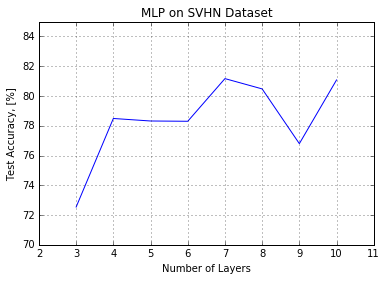

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(8)+3
fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, np.array(acc_3)*100.0)
plt.ylabel('Test Accuracy, [%]')
plt.xlabel('Number of Layers')
plt.title('MLP on SVHN Dataset')
plt.xlim(2, 11)
plt.ylim(70, 85)
plt.show()

Document the choice of parameters, and discuss what you discover.

**Parameters:**
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 250
* batch_size = 20
* n_neurons_in_each_layer = 250
* activation = T.tanh
* improvement_threshold = 0.99

**Observation**

In general, the performance of classifier increases with the number of hidden layers provided the number of neurons in each layer is constant. However, the rate of performance increase decreases with the number of hidden layers.

### Bullet 4: Experiment with the number of hidden layers, but fix the total number of neurons

In [2]:
datasets = load_data()
total_number = 2400; acc_4 = []
for i in range(1, 9):
    n_layer = [2400/(j+1) for j in range(i)]
    acc_4.append(test_mlp(datasets=datasets, activation=T.tanh, n_layer=n_layer, n_epochs=100))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 63.073770 %
     epoch 1, minibatch 3296/3296, test error of best model 63.089931 %
epoch 2, minibatch 3296/3296, validation error 46.557377 %
     epoch 2, minibatch 3296/3296, test error of best model 48.032283 %
epoch 3, minibatch 3296/3296, validation error 35.874317 %
     epoch 3, minibatch 3296/3296, test error of best model 37.855496 %
epoch 4, minibatch 3296/3296, validation error 31.816940 %
     epoch 4, minibatch 3296/3296, test error of best model 33.105304 %
epoch 5, minibatch 3296/3296, validation error 30.054645 %
     epoch 5, minibatch 3296/3296, test error of best model 31.164489 %
epoch 6, minibatch 3296/3296, validation error 28.524590 %
     epoch 6, minibatch 3296/3296, test error of best model 29.850115 %
epoch 7, minibatch 3296/3296, validation error 26.270492 %
     epoch 7, minibatch 3296/3296, test error of best model 27.598002 %
epoch 8, minibatch 3296/3296, 

The code for file __file__ ran for 104.02m


In [6]:
# Keep record due to loss of connection
acc_4 = [1-0.22940046,
1-0.19823213,
1-0.19765565,
1-0.19254420,
1-0.19777095,
1-0.22878555,
1-0.21210607,
1-0.207187678]

Plot the result (reproducing Figure 2)

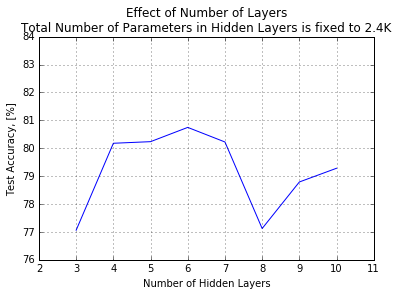

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(8)+3
fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, np.array(acc_4)*100.0)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Test Accuracy, [%]')
plt.title('''Effect of Number of Layers
Total Number of Parameters in Hidden Layers is fixed to 2.4K''')
plt.xlim(2, 11)
plt.ylim(76,84)
plt.show()

Document the choice of parameters, and discuss what you discover.

**Parameters:**
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 100
* batch_size = 20
* activation = T.tanh
* improvement_threshold = 0.99

**Observation**

When the total number of neurons is set, there is a trade off between the number of layers and the number of neurons in each layer.

### Bullet 5: Experiment with the number of neurons in hidden layers, but fix the number of hidden layers

### Situation with single layer:

In [ ]:
datasets = load_data()
n_layer = [[250], [500], [750], [1000], [1250]]
acc_single = []
for i in range(len(n_layer)):
    acc_single.append(test_mlp(datasets=datasets, activation=T.tanh, n_layer=n_layer[i], n_epochs=100))
    print('Best test accuracy with single layer and {} nurons/layer is {}.'.format(n_layer[i], acc_single[i]))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 78.838798 %
     epoch 1, minibatch 3296/3296, test error of best model 78.627978 %

In [9]:
# keep record due to loss of connnectinon
acc_single = [0.725403535742,
             0.761644888547,
             0.795003843198,
             0.747463489623,
             1-0.23989239]

Plot the result (reproducing Figure 3)

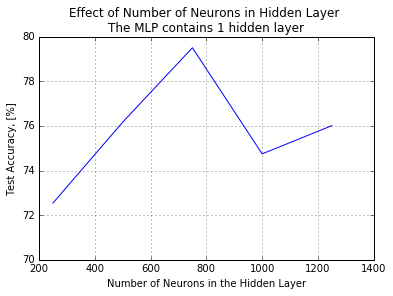

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x = np.array([250*i for i in range(1, 6)])
fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, np.array(acc_single)*100.0)
plt.xlabel('Number of Neurons in the Hidden Layer')
plt.ylabel('Test Accuracy, [%]')
plt.title('''Effect of Number of Neurons in Hidden Layer 
The MLP contains 1 hidden layer''')
plt.xlim(200, 1400)
plt.ylim(70,80)
plt.show()

Document the choice of parameters, and discuss what you discover.

Parameters:
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 100
* batch_size = 20
* n_layer = [[250], [500], [750], [1000], [1250]]
* activation = T.tanh
* improvement_threshold = 0.99

**observation**

From the graph it can be concluded there is no explicit relationship between the number of neurons and the performance of the classifier

### Situation with double layers

In [2]:
datasets = load_data()
n_layer = [#[250,250], [500,500], 
           #[750,750], [1000,1000], 
            [1250,1250]]
acc_double = []
for i in range(len(n_layer)):
    acc_double.append(test_mlp(datasets=datasets, activation=T.tanh, n_layer=n_layer[i], n_epochs=100))
    print('Best test accuracy with double layers and {} nurons/layer is {}.'.format(n_layer[i], acc_double[i]))

... loading data
... building the model
... training
epoch 1, minibatch 3296/3296, validation error 78.756831 %
     epoch 1, minibatch 3296/3296, test error of best model 78.339739 %
epoch 2, minibatch 3296/3296, validation error 63.729508 %
     epoch 2, minibatch 3296/3296, test error of best model 62.786318 %
epoch 3, minibatch 3296/3296, validation error 50.628415 %
     epoch 3, minibatch 3296/3296, test error of best model 53.301307 %
epoch 4, minibatch 3296/3296, validation error 43.142077 %
     epoch 4, minibatch 3296/3296, test error of best model 46.014604 %
epoch 5, minibatch 3296/3296, validation error 38.579235 %
     epoch 5, minibatch 3296/3296, test error of best model 41.452729 %
epoch 6, minibatch 3296/3296, validation error 35.806011 %
     epoch 6, minibatch 3296/3296, test error of best model 38.539585 %
epoch 7, minibatch 3296/3296, validation error 33.866120 %
     epoch 7, minibatch 3296/3296, test error of best model 36.206764 %
epoch 8, minibatch 3296/3296, 

The code for file __file__ ran for 66.81m


In [2]:
# keep record due to loss of connnectinon
acc_double = [0.784896233666,
              0.815180630284,
              0.811337432744,
              0.815411222137,
              0.795311299001]

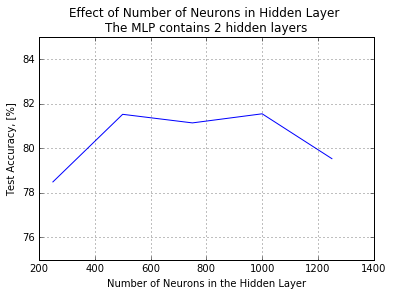

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x = np.array([250*i for i in range(1, 6)])
fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, np.array(acc_double)*100.0)
plt.xlabel('Number of Neurons in the Hidden Layer')
plt.ylabel('Test Accuracy, [%]')
plt.title('''Effect of Number of Neurons in Hidden Layer 
The MLP contains 2 hidden layers''')
plt.xlim(200, 1400)
plt.ylim(75,85)
plt.show()

Parameters:
* learning_rate = 0.01
* L1_reg = 0.00
* L2_reg = 0.0001
* n_epochs = 100
* batch_size = 20
* n_layer = [[250,250], [500,500], [750,750], [1000,1000], [1250,1250]]
* activation = T.tanh
* improvement_threshold = 0.99

**Observation**

The same conclusion as that with single hidden layers: there is no explicit relationship between the number of neurons and the performance of classifier.